# Correlation Heatmap

In [122]:
import pandas as pd
cleaned_data = pd.read_csv("Airbnb_Open_Data_cleaned.csv")

<Figure size 1400x1200 with 0 Axes>

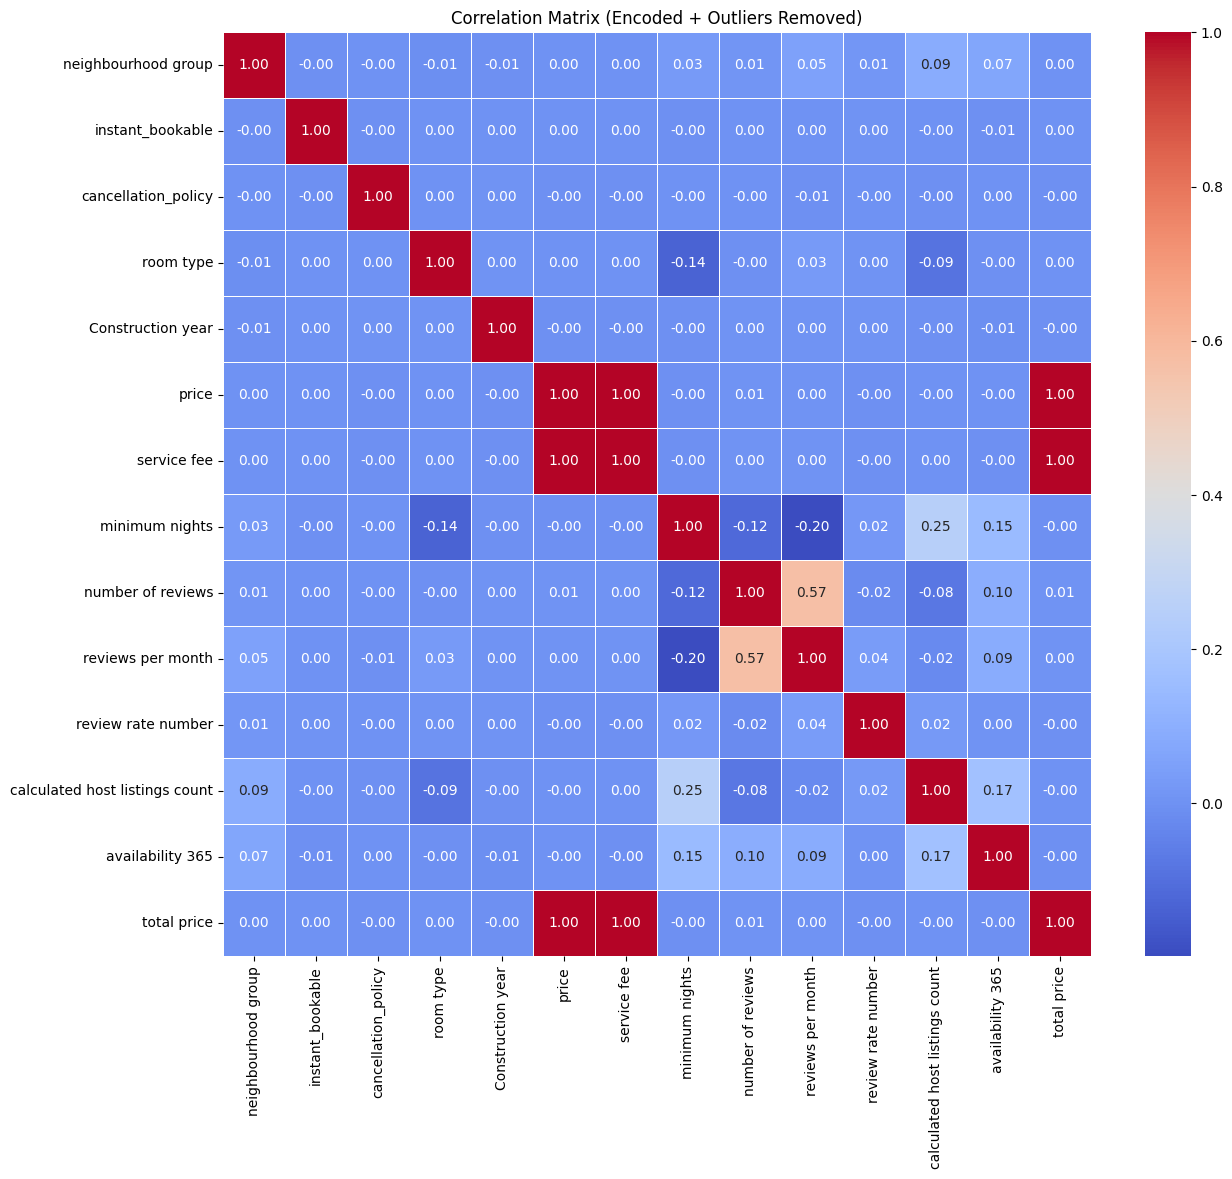

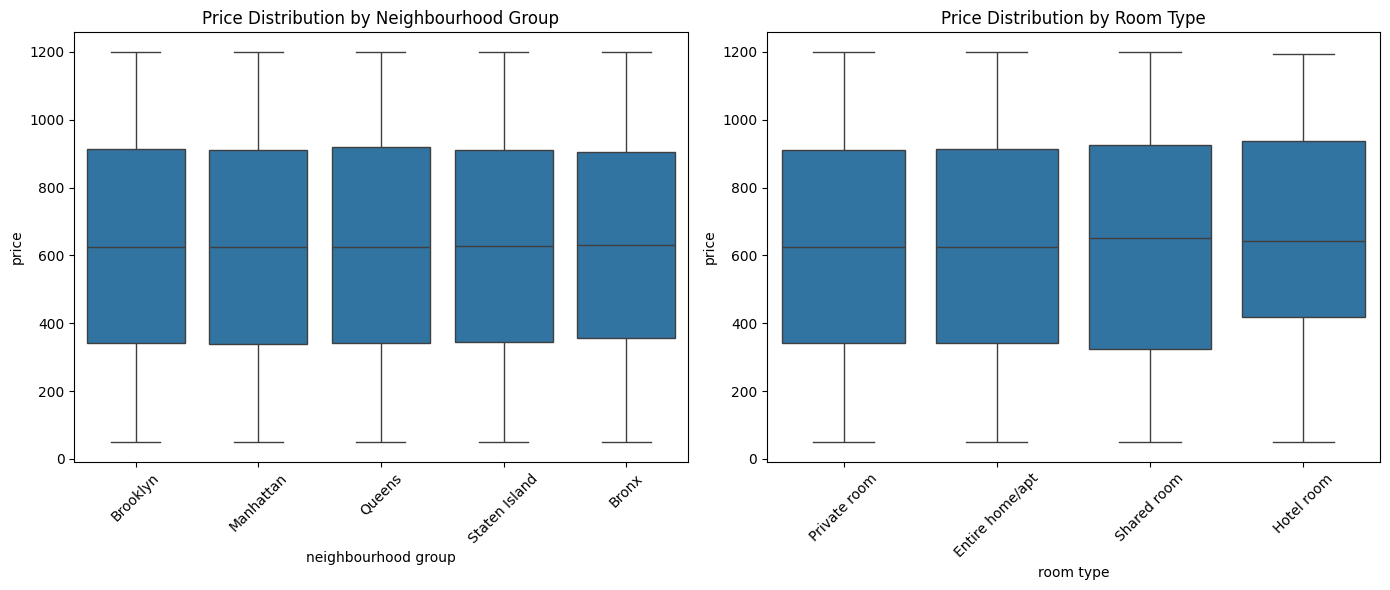

In [123]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------
# 1. PRE-PROCESSING
# ---------------------------------------------------------
df_analysis = cleaned_data.copy()

# Robust function to clean currency columns
def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', '').strip())
    return x

if 'price' in df_analysis.columns:
    df_analysis['price'] = df_analysis['price'].apply(clean_currency)
if 'service fee' in df_analysis.columns:
    df_analysis['service fee'] = df_analysis['service fee'].apply(clean_currency)

drop_cols = ['id', 'NAME', 'host id', 'host name', 'country', 'country code', 'license', 'house_rules', 'host_identity_verified', 'last review']
df_analysis = df_analysis.drop(columns=[c for c in drop_cols if c in df_analysis.columns], errors='ignore')

# ---------------------------------------------------------
# PART 1: ENCODED HEATMAP (With Numbers)
# ---------------------------------------------------------
df_encoded = df_analysis.copy()

cat_cols = ['neighbourhood group', 'neighbourhood', 'cancellation_policy', 'room type', 'instant_bookable']
le = LabelEncoder()
for col in cat_cols:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].astype(str)
        df_encoded[col] = le.fit_transform(df_encoded[col])

plt.figure(figsize=(14, 12)) # Made figure slightly larger for numbers
corr_encoded = df_encoded.corr(numeric_only=True)



# ---------------------------------------------------------
# PART 2: FILTERED HEATMAP (With Numbers)
# ---------------------------------------------------------
df_filtered = df_encoded[
    (df_encoded['price'] > 0) &
    (df_encoded['minimum nights'] < 365)
].copy()

plt.figure(figsize=(14, 12))
corr_filtered = df_filtered.corr(numeric_only=True)
sns.heatmap(corr_filtered, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Encoded + Outliers Removed)")
plt.show()

# ---------------------------------------------------------
# PART 3: BOX PLOTS
# ---------------------------------------------------------
df_viz = df_analysis[
    (df_analysis['price'] > 0) & 
    (df_analysis['minimum nights'] < 365)
]

plt.figure(figsize=(14, 6))

if 'neighbourhood group' in df_viz.columns:
    plt.subplot(1, 2, 1)
    sns.boxplot(x='neighbourhood group', y='price', data=df_viz)
    plt.title('Price Distribution by Neighbourhood Group')
    plt.xticks(rotation=45)

if 'room type' in df_viz.columns:
    plt.subplot(1, 2, 2)
    sns.boxplot(x='room type', y='price', data=df_viz)
    plt.title('Price Distribution by Room Type')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# FP-Growth

In [124]:
import sys
!{sys.executable} -m pip install pyfpgrowth

In [125]:
import pandas as pd
import pyfpgrowth

if "cleaned_data" not in globals():
    cleaned_data = pd.read_csv("Airbnb_Open_Data_cleaned.csv")

categorical_cols = [
    "host_identity_verified",
    "neighbourhood group",
    "instant_bookable",
    "cancellation_policy",
    "room type",
]

existing_cat = [c for c in categorical_cols if c in cleaned_data.columns]
transactions = []
for _, row in cleaned_data[existing_cat].astype("string").iterrows():
    items = [f"{col}={row[col]}" for col in existing_cat if pd.notna(row[col])]
    transactions.append(items)

# min_support is absolute count here
min_support = int(0.05 * len(transactions))
patterns = pyfpgrowth.find_frequent_patterns(transactions, min_support)
rules = pyfpgrowth.generate_association_rules(patterns, 0.6)  # min confidence

# Keep only 1->1 pairs
pairs = []
for antecedent, (consequent, confidence) in rules.items():
    if len(antecedent) == 1 and len(consequent) == 1:
        pairs.append((antecedent[0], consequent[0], confidence))

pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:20]
pairs

[]

# Normalisation 

In [126]:
# Normalisation and encoding

keep_cols = [
    "number of reviews",
    "number of review",
    "reviews per month",
    "review rate number",
    "total price",
]
existing_cols = [c for c in keep_cols if c in cleaned_data.columns]
cleaned_data = cleaned_data[existing_cols].copy()

# Min-max normalization for numeric columns
numeric_cols = [
    "number of reviews",
    "reviews per month",
    "review rate number",
    "total price",
]

for col in numeric_cols:
    if col not in cleaned_data.columns:
        continue
    values = pd.to_numeric(cleaned_data[col], errors="coerce")
    min_val = values.min(skipna=True)
    max_val = values.max(skipna=True)
    denom = (max_val - min_val) if pd.notna(max_val) and pd.notna(min_val) else None

    norm_col = f"{col}_norm"
    if denom and denom != 0:
        if col == "total price":
            # Invert price so lower price = higher normalized score
            cleaned_data[norm_col] = (max_val - values) / denom
        else:
            cleaned_data[norm_col] = (values - min_val) / denom
    else:
        cleaned_data[norm_col] = pd.NA

cleaned_data[[c for c in cleaned_data.columns if c.endswith("_num") or c.endswith("_norm")]].head()


,number of reviews_norm,reviews per month_norm,review rate number_norm,total price_norm
0,0.008789,0.002222,0.75,0.203623
1,0.043945,0.004112,0.75,0.920290
2,0.000000,0.015173,1.00,0.504348
3,0.263672,0.051450,0.75,0.723188
4,0.008789,0.001000,0.50,0.865942


# Classification

In [127]:
# Create weighted score column
score_features = {
    "total price_norm": 0.3,
    "number of reviews_norm": 0.2,
    "reviews per month_norm": 0.2,
    "review rate number_norm": 0.3
}

existing_features = [c for c in score_features if c in cleaned_data.columns]
if not existing_features:
    raise KeyError("No score feature columns found. Run the normalization/encoding cell first.")

weights = pd.Series({k: score_features[k] for k in existing_features})
values = cleaned_data[existing_features].apply(pd.to_numeric, errors="coerce")

weighted_sum = values.mul(weights, axis=1).sum(axis=1, skipna=True)
weight_sum = values.notna().mul(weights, axis=1).sum(axis=1)

cleaned_data["score"] = weighted_sum.div(weight_sum).where(weight_sum != 0)

# Normalize score to 0-1
score_values = pd.to_numeric(cleaned_data["score"], errors="coerce")
score_min = score_values.min(skipna=True)
score_max = score_values.max(skipna=True)
score_denom = score_max - score_min if pd.notna(score_min) and pd.notna(score_max) else None

if score_denom and score_denom != 0:
    cleaned_data["score_norm"] = (score_values - score_min) / score_denom
else:
    cleaned_data["score_norm"] = pd.NA

# Categorise normalized score (balanced by quantiles)
score_labels = ["Risky", "Standard", "Elite"]
try:
    cleaned_data["score_category"] = pd.qcut(
        cleaned_data["score_norm"],
        q=[0, 1 / 3, 2 / 3, 1],
        labels=score_labels,
        duplicates="drop",
    )
except ValueError:
    score_bins = [0, 0.6, 0.8, 1]
    cleaned_data["score_category"] = pd.cut(
        cleaned_data["score_norm"],
        bins=score_bins,
        labels=score_labels,
        include_lowest=True,
    )

# Domain override: low reviews or low rating => Risky
if "number of reviews" in cleaned_data.columns:
    low_reviews = pd.to_numeric(
        cleaned_data["number of reviews"], errors="coerce"
    ) <= 5
else:
    low_reviews = pd.Series(False, index=cleaned_data.index)

if "review rate number" in cleaned_data.columns:
    low_rating = pd.to_numeric(
        cleaned_data["review rate number"], errors="coerce"
    ) < 3
else:
    low_rating = pd.Series(False, index=cleaned_data.index)

cleaned_data.loc[low_reviews | low_rating, "score_category"] = "Risky"

cleaned_data[["score", "score_norm", "score_category"] + existing_features].head()


,score,score_norm,score_category,total price_norm,number of reviews_norm,reviews per month_norm,review rate number_norm
0,0.288289,0.326610,Standard,0.203623,0.008789,0.002222,0.75
1,0.510698,0.579463,Elite,0.920290,0.043945,0.004112,0.75
2,0.454339,0.515389,Risky,0.504348,0.000000,0.015173,1.00
3,0.504981,0.572963,Elite,0.723188,0.263672,0.051450,0.75
4,0.411740,0.466959,Elite,0.865942,0.008789,0.001000,0.50


In [128]:
# Training dataframe: normalized columns + score + score category (first 80% of source CSV)
source_df = pd.read_csv("Airbnb_Open_Data_cleaned.csv")
normalized_cols = [c for c in cleaned_data.columns if c.endswith("_norm")]
required_cols = normalized_cols + ["score_category"]

missing = [c for c in required_cols if c not in cleaned_data.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}. Run normalization/score cells first.")

train_rows = int(len(source_df) * 0.8)
train_df = cleaned_data[required_cols].iloc[:train_rows].copy()

# Save training data
train_df.to_csv("training_data.csv", index=False)

train_df.head()

,number of reviews_norm,reviews per month_norm,review rate number_norm,total price_norm,score_norm,score_category
0,0.008789,0.002222,0.75,0.203623,0.326610,Standard
1,0.043945,0.004112,0.75,0.920290,0.579463,Elite
2,0.000000,0.015173,1.00,0.504348,0.515389,Risky
3,0.263672,0.051450,0.75,0.723188,0.572963,Elite
4,0.008789,0.001000,0.50,0.865942,0.466959,Elite


In [129]:
# Decision Tree model (classification)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Build test set from the remaining 20%
test_df = cleaned_data[required_cols].iloc[train_rows:].copy()

# Drop rows with missing values in features/target
train_df = train_df.dropna(subset=required_cols)
test_df = test_df.dropna(subset=required_cols)

X_train = train_df[normalized_cols]
y_train = train_df["score_category"]
X_test = test_df[normalized_cols]
y_test = test_df["score_category"]

clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_leaf=10,
)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

# Save test results with predictions
results_df = test_df.copy()
results_df["predicted_category"] = pred
results_df.to_csv("test_results.csv", index=False)

Accuracy: 1.0
              precision    recall  f1-score   support

       Elite       1.00      1.00      1.00      3777
       Risky       1.00      1.00      1.00     14008
    Standard       1.00      1.00      1.00      2627

    accuracy                           1.00     20412
   macro avg       1.00      1.00      1.00     20412
weighted avg       1.00      1.00      1.00     20412

[[ 3777     0     0]
 [    0 14008     0]
 [    0     0  2627]]


In [130]:
# Save decision tree artifacts for app.py
import json
import pickle

score_min = None
score_max = None
score_features = {
    "total price_norm": 0.4,
    "number of reviews_norm": 0.3,
    "review rate number_norm": 0.3,
}
if all(col in train_df.columns for col in score_features):
    score_values = (
        pd.to_numeric(train_df["total price_norm"], errors="coerce") * 0.4
        + pd.to_numeric(train_df["number of reviews_norm"], errors="coerce") * 0.3
        + pd.to_numeric(train_df["review rate number_norm"], errors="coerce") * 0.3
    )
    score_min = score_values.min(skipna=True)
    score_max = score_values.max(skipna=True)

reviews_per_month_norm_default = None
if "reviews per month_norm" in train_df.columns:
    reviews_per_month_norm_default = pd.to_numeric(
        train_df["reviews per month_norm"], errors="coerce"
    ).median(skipna=True)

meta = {
    "normalized_cols": normalized_cols,
    "score_min": None if pd.isna(score_min) else float(score_min),
    "score_max": None if pd.isna(score_max) else float(score_max),
    "reviews_per_month_norm_default": None
    if pd.isna(reviews_per_month_norm_default)
    else float(reviews_per_month_norm_default),
}

with open("decision_tree_model.pkl", "wb") as model_file:
    pickle.dump(clf, model_file)

with open("decision_tree_meta.json", "w", encoding="utf-8") as meta_file:
    json.dump(meta, meta_file, indent=2)

print("Saved decision_tree_model.pkl and decision_tree_meta.json")


Saved decision_tree_model.pkl and decision_tree_meta.json


In [131]:
# Check score category distribution
print(cleaned_data["score_norm"].describe())
print(cleaned_data["score_category"].value_counts(dropna=False))


count    102058.000000
mean          0.373611
std           0.148170
min           0.000000
25%           0.268909
50%           0.376545
75%           0.481776
max           1.000000
Name: score_norm, dtype: float64
score_category
Risky       69837
Elite       19196
Standard    13025
Name: count, dtype: int64
